In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [2]:
class MultiArmBandit:
    """
    This class is what our agents will interact with.
    In __init__:
    - It instantiates the arms' reward distributions (normal distributions with different means and variances)
    - It sets the step counter to 0
    - It initialises the reward, action, regret lists
    In pull_arm:
    - It increments the step counter
    - It samples the reward from the arm's reward distribution
    - It calculates the regret
    - It returns the reward
    """
    def __init__(self, k, mean_min=5, mean_max=10, std_min=1., std_max=5.):
        self.n_arms = k
        self.arms_means = np.random.randint(mean_min, mean_max, k)
        self.arms_std = np.random.randint(std_min, std_max, k)
        self.arms_means[8] = 11.
        self.arms_std[8] = 2.
        self.arms_means[4] = 12.
        self.arms_std[4] = 2.
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []

    def pull_arm(self, arm):
        self.step += 1
        reward = np.random.normal(loc=self.arms_means[arm], scale=self.arms_std[arm])
        regret = np.max(self.arms_means) - self.arms_means[arm]
        self.reward_list.append(reward)
        self.action_list.append(arm)
        self.regret_list.append(regret)
        return reward
    
    def reset(self):
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []

In [3]:
class BanditAgent:
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class RandomAgent(BanditAgent):
    # This agent chooses a random arm at each step
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def select_arm(self):
        return np.random.randint(0, self.n_arms)
    def update(self, arm, reward):
        pass
    
class QAgent(BanditAgent):
    def __init__(self, n_arms):
        self.q_values = np.zeros(n_arms)
        self.n_selections = np.zeros(n_arms)
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class GreedyQAgent(QAgent):
    # This agent estimates the average reward of each arm (q-value)
    # and selects the arm with the highest q-value at each step
    def select_arm(self):
        return np.argmax(self.q_values)
    def update(self, arm, reward):
        self.n_selections[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.n_selections[arm]

class EpsilonGreedyQAgent(QAgent):
    # This agent selects a random arm with probability epsilon
    # and selects the arm with the highest q-value with probability 1 - epsilon
    def __init__(self, n_arms, epsilon=0.1):
        super().__init__(n_arms)
        self.epsilon = epsilon
    def select_arm(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, len(self.q_values))
        else:
            return np.argmax(self.q_values)
    def update(self, arm, reward):
        self.q_values[arm] = reward

class UCBAgent(QAgent):
    # This agent selects the arm with the highest Upper Confidence Bound (UCB)
    # The UCB is the sum of the q-value and a term that increases with the total 
    # number of steps and decreases with the number of times the arm has been selected
    def __init__(self, n_arms, c=1.):
        super().__init__(n_arms)
        self.c = c
    def select_arm(self):
        if 0 in self.n_selections:
            return np.argmin(self.n_selections)
        ucb_values = self.q_values + self.c * np.sqrt(np.log(np.sum(self.n_selections)) / (self.n_selections))
        return np.argmax(ucb_values)
    def update(self, arm, reward):
        self.n_selections[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.n_selections[arm]

agents = {
    'Random': RandomAgent,
    'EpsilonGreedy': EpsilonGreedyQAgent,
    'UCB': UCBAgent,
}

logs = {agent_name: {
    'Reward at timestep t': [],
    'Action at timestep t': [],
    'Regret at timestep t': [],
    'Cumulative Regret': [],
} for agent_name in agents.keys()
}

In [4]:
k = 50
n_episodes = 100
ep_len = 1000
bandit = MultiArmBandit(k)
for agent_name, Algo in agents.items():
    print(f'Running {agent_name}')
    for _ in tqdm(range(n_episodes)):
        agent = Algo(bandit.n_arms)
        for _ in range(ep_len):
            arm = agent.select_arm()
            reward = bandit.pull_arm(arm)
            agent.update(arm, reward)
        logs[agent_name]['Reward at timestep t'].append(deepcopy(bandit.reward_list))
        logs[agent_name]['Action at timestep t'].append(deepcopy(bandit.action_list))
        logs[agent_name]['Regret at timestep t'].append(deepcopy(bandit.regret_list))
        logs[agent_name]['Cumulative Regret'].append(np.cumsum(bandit.regret_list))
        bandit.reset()

Running Random


100%|██████████| 100/100 [00:01<00:00, 65.80it/s]


Running EpsilonGreedy


100%|██████████| 100/100 [00:01<00:00, 57.23it/s]


Running UCB


100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


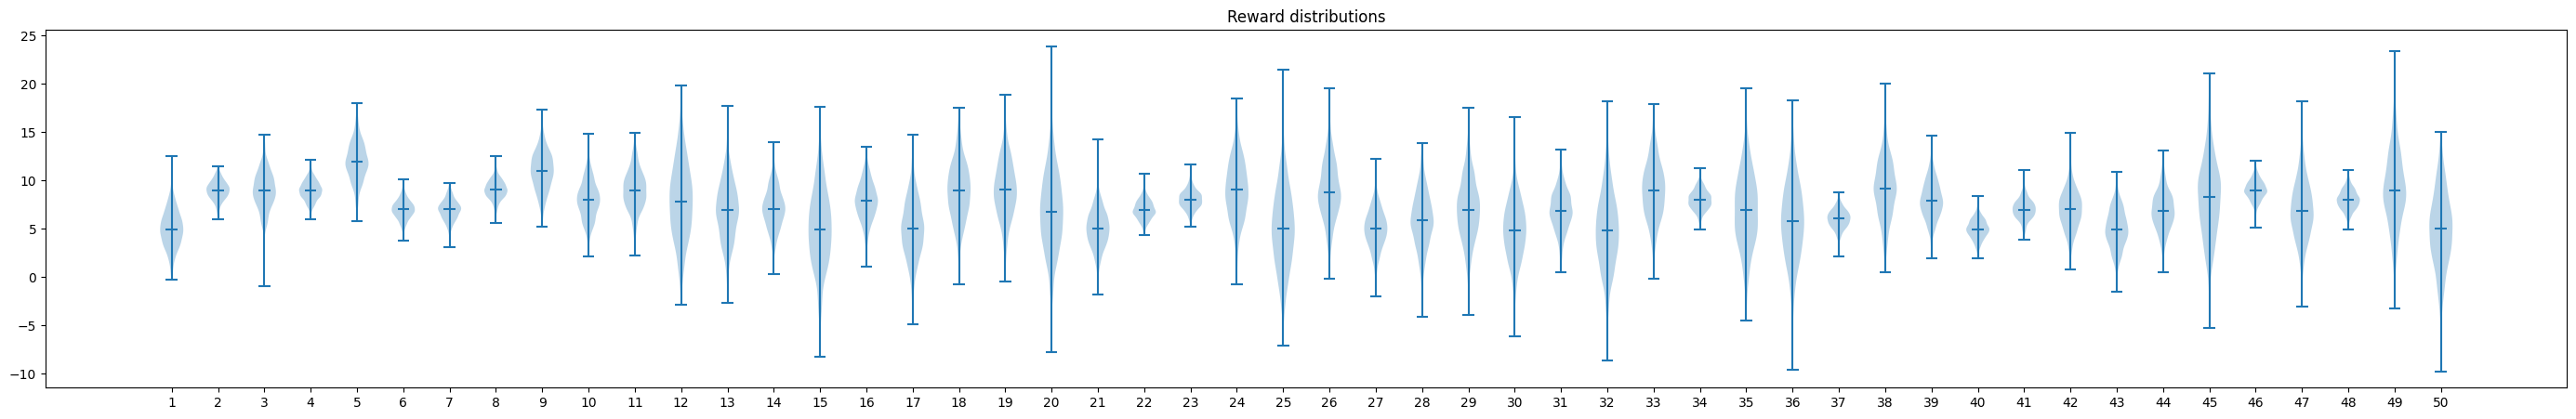

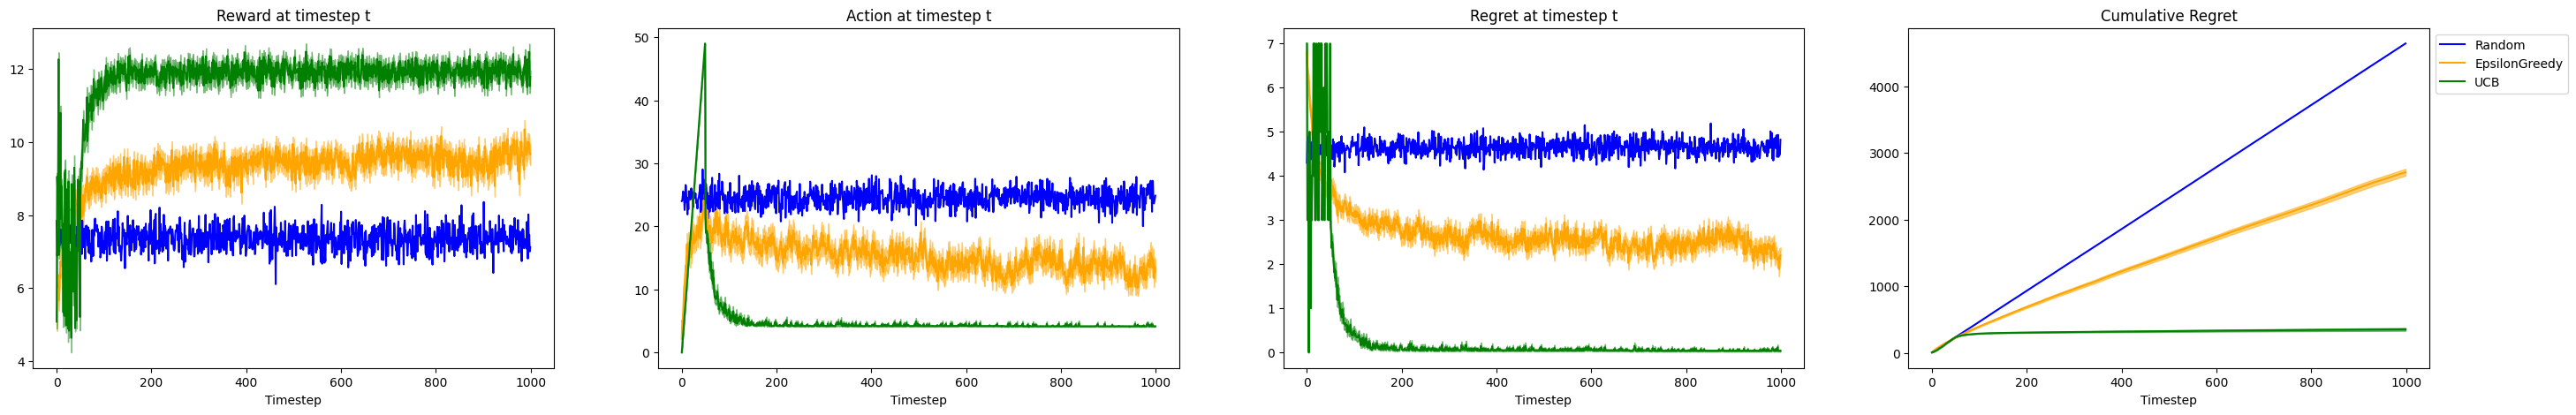

In [5]:
# plot reward distributions
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
ax.set_title('Reward distributions')
arm_stats = np.zeros((bandit.n_arms, 1000))
for i, (mean, std) in enumerate(zip(bandit.arms_means, bandit.arms_std)):
    arm_stats[i] = np.random.normal(loc=mean, scale=std, size=1000)
ax.violinplot(arm_stats.T, showmeans=False, showmedians=True)
ax.set_xticks(np.arange(1, bandit.n_arms + 1))
ax.set_xticklabels(np.arange(1, bandit.n_arms + 1))

# plot algorithm performance
fig, ax = plt.subplots(1, 4, figsize=(35, 5))


all_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
agent_colors = {agent_name: color for agent_name, color in zip(agents.keys(), all_colors)}

for agent_name, agent_logs in logs.items():
    for i, metric in enumerate(agent_logs.keys()):
        color = agent_colors[agent_name]
        mean = np.mean(agent_logs[metric], axis=0)
        ste = np.std(agent_logs[metric], axis=0) / np.sqrt(n_episodes)
        
        ax[i].plot(mean, label=agent_name, color=color)
        ax[i].set_xlabel('Timestep')
        ax[i].set_title(metric)
        if agent_name in ['EpsilonGreedy', 'UCB']:
            ax[i].fill_between(range(ep_len), mean - ste, mean + ste, alpha=0.5, color=color)
    
ax[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))


# Appendix

### Online mean v.s. arithmetic mean

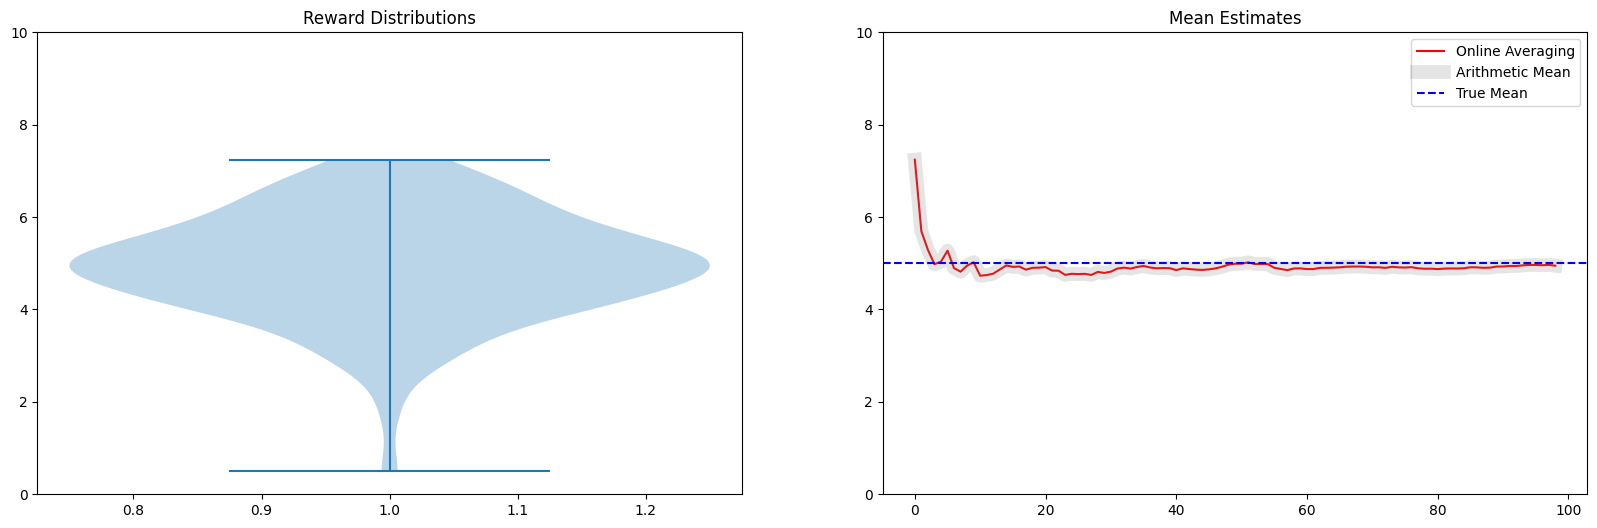

In [6]:
# simply test the ability of this online update rule to estimate a mean over time
real_mean = 5.
dist = torch.distributions.Normal(real_mean, 1.2)
all_samples = []
online_mean = []
regular_mean = []
last_online_mean = 0.
for t in range(1, 100):
    all_samples.append(float(dist.sample()))
    online_mean.append(last_online_mean + (all_samples[-1] - last_online_mean) / t)
    regular_mean.append(np.mean(all_samples))
    last_online_mean = online_mean[-1]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# violin plot for the reward distributions
ax[0].violinplot(all_samples)
ax[0].set_title('Reward Distributions')
ax[0].set_ylim(0, 10)

# plot the online and regular mean estimates over time
ax[1].plot(online_mean, label='Online Averaging', color='red')
ax[1].plot(regular_mean, label='Arithmetic Mean', color='gray', alpha=0.2, linewidth=10.)
ax[1].axhline(real_mean, color='blue', linestyle='--', label='True Mean')
ax[1].legend()
ax[1].set_title('Mean Estimates')
ax[1].set_ylim(0, 10)
plt.show()